In [93]:
## importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
## importamos los datos
sujetos = [1,2,3,4,6,8,10]
combinaciones = [1,2,3,4]
tareas = ["ejecutado", "imaginado"] #

## por cada sujeto cargamos los datos en el txt y luego en un dataframe y vamos concatenando cada dataframe
## seteamos los índeces en LDA y SVM
for c in combinaciones:
    for t in tareas:
        for i in sujetos: #contatenamos los dataframes de cada sujeto
            path = f"data\\sujeto_{i}\\dataframes\\df_{t}_comb{c}.txt"
            data = pd.read_csv(path, sep = '\t')
            if i == 1:
                df = data
            else:
                df = pd.concat([df, data], axis = 0)

        df.rename(columns = {'Unnamed: 0':'Clasificador'}, inplace = True)
        df.set_index('Clasificador', inplace = True)
        df["Precision"] = (df["Precision"]*100).round(2)
        df["Recall"] = (df["Recall"].round(2)*100).round(2)
        df["F1-Score"] = (df["F1-Score"]*100).round(2)

        df.loc["Avg-std(LDA)"] = df.loc["LDA"].mean().round(2).astype(str) + " +- " + df.loc["LDA"].std().round(2).astype(str)
        df.loc["Avg-std(SVM)"] = df.loc["SVM"].mean().round(2).astype(str) + " +- " + df.loc["SVM"].std().round(2).astype(str)


        ## guardamos el dataframe en un csv
        filename = f"data\\promedios\\promedios_{t}_comb{c}.csv"
        df.to_csv(filename, sep = '\t')
        print(f"Guardamos el dataframe en {filename}")

Guardamos el dataframe en data\promedios\promedios_ejecutado_comb1.csv
Guardamos el dataframe en data\promedios\promedios_imaginado_comb1.csv
Guardamos el dataframe en data\promedios\promedios_ejecutado_comb2.csv
Guardamos el dataframe en data\promedios\promedios_imaginado_comb2.csv
Guardamos el dataframe en data\promedios\promedios_ejecutado_comb3.csv
Guardamos el dataframe en data\promedios\promedios_imaginado_comb3.csv
Guardamos el dataframe en data\promedios\promedios_ejecutado_comb4.csv
Guardamos el dataframe en data\promedios\promedios_imaginado_comb4.csv


### Análisis de señal

In [177]:

import numpy as np
import pandas as pd

from TrialsHandler.TrialsHandler import TrialsHandler
from TrialsHandler.Concatenate import Concatenate

from SignalProcessor.Filter import Filter
from SignalProcessor.CSPMulticlass import CSPMulticlass
from SignalProcessor.FeatureExtractor import FeatureExtractor
from SignalProcessor.RavelTransformer import RavelTransformer
    
## Clasificadores LDA y SVM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

## Librerias para entrenar y evaluar el modelo
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import pickle
import os

In [178]:

### ********** Cargamos los datos **********
sujeto = "sujeto_6" #4 no, 5 no
tipoTarea = "ejecutado" #imaginado
ct = 0 if tipoTarea == "ejecutado" else 1 #0 ejecutado, 1 imaginado
comb = 1
r = 1

nrows = 4#"auto" ## auto para comb 1 y 2, 3 filas x 4 columnas para comb 3.... y 5 filas x f columnas para comb4
ncols = 3#"auto"

baseFolder = f"data\{sujeto}"
eventosFile = f"{baseFolder}\eegdata\sesion1\sn1_ts0_ct{ct}_r{r}_events.txt"
file = f"{baseFolder}\eegdata\sesion1\sn1_ts0_ct{ct}_r{r}.npy"
rawEEG_1 = np.load(file)
eventos_1 = pd.read_csv(eventosFile, sep = ",")

eventosFile = f"{baseFolder}\eegdata\sesion2\sn2_ts0_ct{ct}_r{r}_events.txt"
file = f"{baseFolder}\eegdata\sesion2\sn2_ts0_ct{ct}_r{r}.npy"
rawEEG_2 = np.load(file)
eventos_2 = pd.read_csv(eventosFile, sep = ",")

#Creamos objetos para manejar los trials
th_1 = TrialsHandler(rawEEG_1, eventos_1, tinit = 0, tmax = 4, reject=None, sample_rate=250., trialsToRemove = [])
th_2 = TrialsHandler(rawEEG_2, eventos_2, tinit = 0, tmax = 4, reject=None, sample_rate=250., trialsToRemove = [])

dataConcatenada = Concatenate([th_1,th_2])#concatenamos datos

channelsName = ["P3", "P4", "C3", "C4", "F3", "F4", "PZ", "CZ"]
channelsSelected = [0,1,2,3,6,7]

trials = dataConcatenada.trials

#me quedo con channelsSelected
trials = trials[:,channelsSelected,:]
labels = dataConcatenada.labels
classesName, labelsNames = dataConcatenada.classesName

comb1 = np.where((labels == 1) | (labels == 2))
comb2 = np.where((labels == 1) | (labels == 2) | (labels == 5))
comb3 = np.where((labels == 1) | (labels == 2) | (labels == 4) | (labels == 5))
comb4 = np.where((labels == 1) | (labels == 2) | (labels == 3) | (labels == 4) | (labels == 5))

combs = [comb1, comb2, comb3, comb4]

#filtramos los trials para las clases que nos interesan
trials = trials[combs [comb-1]]
labels = labels[combs [comb-1]]

### ********** Separamos los datos en train, validation y test **********
eeg_train, eeg_test, labels_train, labels_test = train_test_split(trials, labels, test_size=0.1, stratify=labels, random_state=42)


Se han extraido 75 trials
Se han extraido 8 canales
Se han extraido 1000 muestras por trial
Se han removido los trials []
Se han extraido 75 trials
Se han extraido 8 canales
Se han extraido 1000 muestras por trial
Se han removido los trials []


### Cargo el pipeline

In [182]:
## cargamos con pickle el modelo entrenado desde data\sujeto_3\pipelines\best_lda_ejecutado_comb1.pkl
filename = f"data\sujeto_6\pipelines\\best_svc_ejecutado_comb1.pkl"
with open(filename, 'rb') as file:
    pipeline = pickle.load(file)

In [180]:
labels_train

array([2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 2, 1, 2, 1])

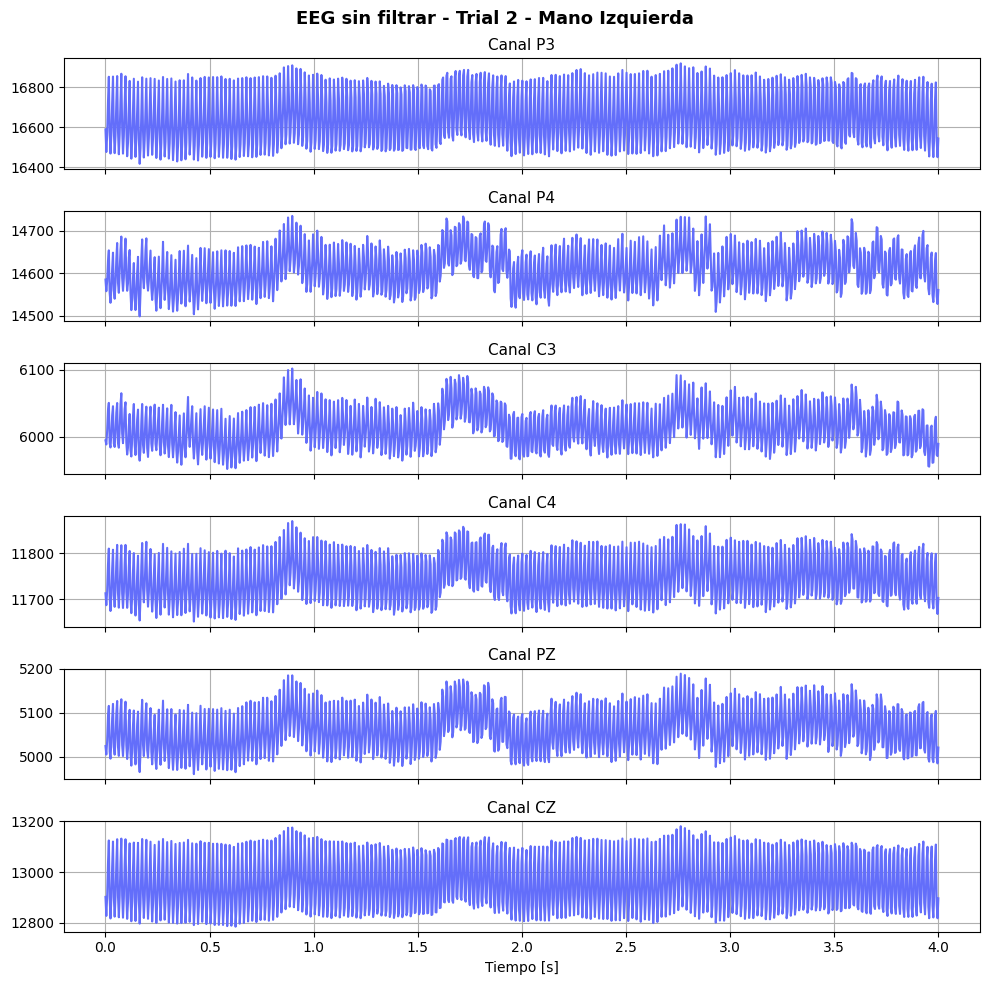

In [181]:
t = np.linspace(0,4,1000)
trial = 2
fig, axes = plt.subplots(len(channelsSelected),1, figsize = (10,10), sharex=True)

for i,channel in enumerate(channelsSelected):
    axes[i].plot(t, eeg_train[trial-1,i,:], color = "#636efa")
    axes[i].set_title(f"Canal {channelsName[channel]}", fontsize = 11)
    # axes[i].set_ylabel("Amplitud [uV]")
    axes[i].grid()

##agrego subtitulo con negrita y tamaño 16
fig.suptitle(f"EEG sin filtrar - Trial {trial} - Mano Izquierda", fontsize=13, fontweight="bold")
plt.xlabel("Tiempo [s]")
plt.tight_layout()
plt.show()


## Aplicamos filtro usando el pipeline

In [134]:
## Aplicamos filtro usando el pipeline que ya tenemos entrenado y se llama pasabanda dentro de pipeline
eeg_train_filt = pipeline["pasabanda"].transform(eeg_train)

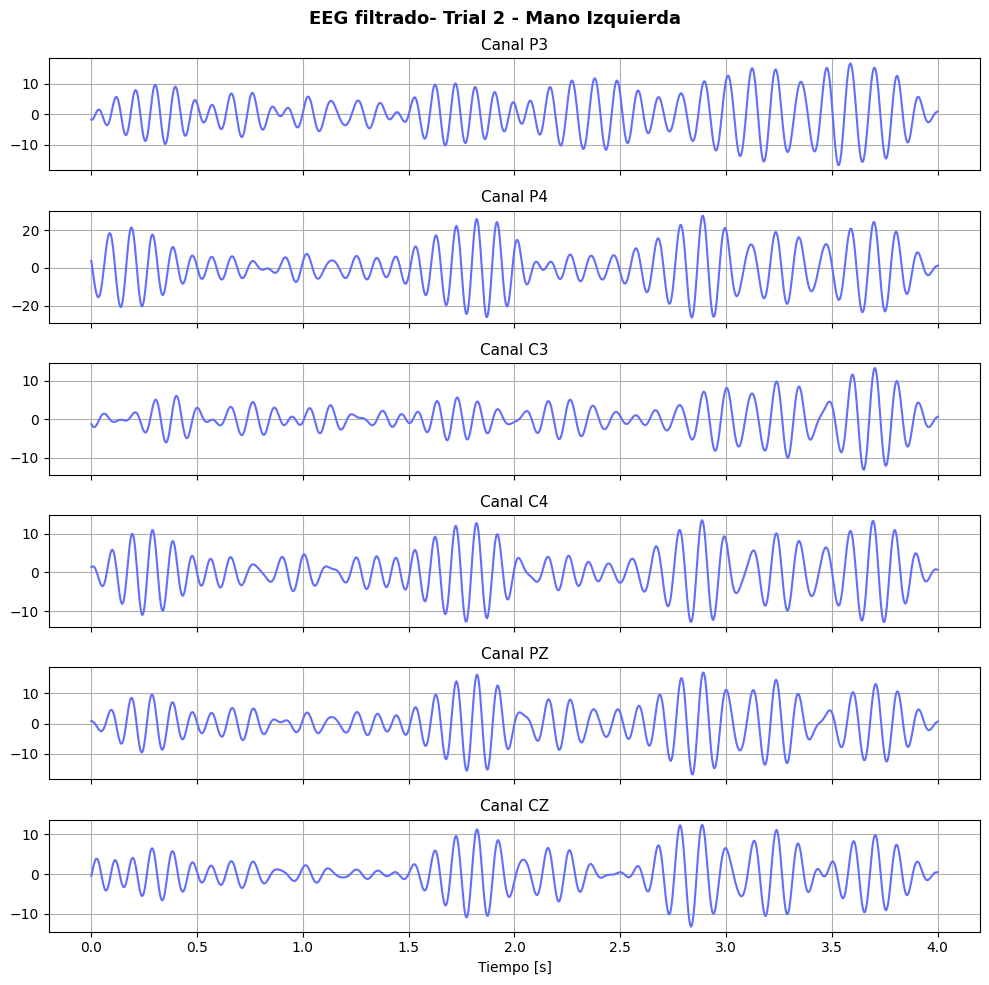

In [142]:
t = np.linspace(0,4,1000)
trial = 2
fig, axes = plt.subplots(len(channelsSelected),1, figsize = (10,10), sharex=True)

for i,channel in enumerate(channelsSelected):
    axes[i].plot(t, eeg_train_filt[trial-1,i,:], color = "#636efa")
    axes[i].set_title(f"Canal {channelsName[channel]}", fontsize = 11)
    # axes[i].set_ylabel("Amplitud [uV]")
    axes[i].grid()

##agrego subtitulo con negrita y tamaño 16
fig.suptitle(f"EEG filtrado- Trial {trial} - Mano Izquierda", fontsize=13, fontweight="bold")
plt.xlabel("Tiempo [s]")
plt.tight_layout()
plt.show()

### Ahora aplicamos el CSP y graficamos las componentes

In [137]:
## aplicamos hasta el CSP cspmulticlase
eeg_train_csp = pipeline["cspmulticlase"].transform(eeg_train_filt)

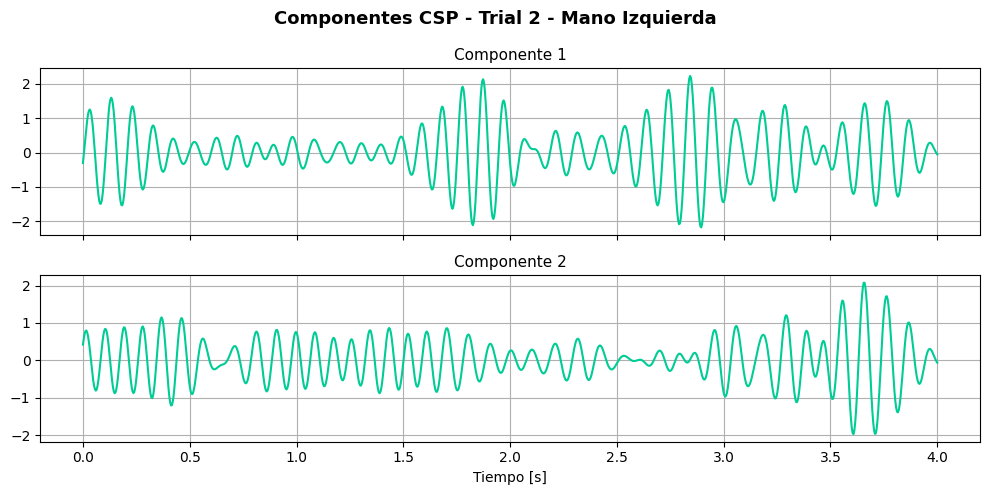

In [143]:
t = np.linspace(0,4,1000)
trial = 2
fig, axes = plt.subplots(eeg_train_csp.shape[1],1, figsize = (10,5), sharex=True)

for i,componente in enumerate([1,2]):
    axes[i].plot(t, eeg_train_csp[trial-1,i,:], color = "#00cc96")
    axes[i].set_title(f"Componente {componente}", fontsize = 11)
    # axes[i].set_ylabel("Amplitud [uV]")
    axes[i].grid()

##agrego subtitulo con negrita y tamaño 16
fig.suptitle(f"Componentes CSP - Trial {trial} - Mano Izquierda", fontsize=13, fontweight="bold")
plt.xlabel("Tiempo [s]")
plt.tight_layout()
plt.show()

### Extraemos características

In [147]:
## aplicamos featureExtractor del pipeline al eeg con csp
eeg_train_features = pipeline["featureExtractor"].transform(eeg_train_csp)


array([ 8.7890625,  9.765625 , 10.7421875, 11.71875  , 12.6953125,
       13.671875 , 14.6484375, 15.625    , 16.6015625, 17.578125 ])

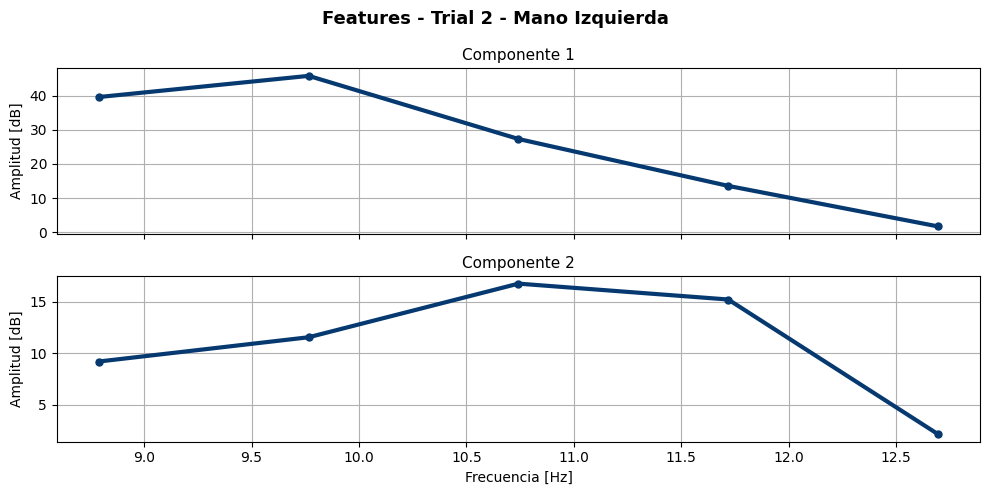

In [174]:
t = np.linspace(0,4,1000)
trial = 2
fig, axes = plt.subplots(eeg_train_csp.shape[1],1, figsize = (10,5), sharex=True)

for i,componente in enumerate([1,2]):
    axes[i].plot(pipeline["featureExtractor"].freqs[:5],eeg_train_features[trial-1,i,:5],
                 color = "#063970", linewidth = 3, marker = "o", markersize = 5)
    axes[i].set_title(f"Componente {componente}", fontsize = 11)
    axes[i].set_ylabel("Amplitud [dB]")
    axes[i].grid()

##agrego subtitulo con negrita y tamaño 16
fig.suptitle(f"Features - Trial {trial} - Mano Izquierda", fontsize=13, fontweight="bold")
plt.xlabel("Frecuencia [Hz]")
plt.tight_layout()
plt.show()

In [153]:
## contactenamos con ravelTransformer del pipeline
eeg_train_features_ravel = pipeline["ravelTransformer"].transform(eeg_train_features)

In [ ]:
t = np.linspace(0,4,1000)
trial = 2
fig, axes = plt.subplots(eeg_train_csp.shape[1],1, figsize = (10,5), sharex=True)

for i,componente in enumerate([1,2]):
    axes[i].plot(pipeline["featureExtractor"].freqs[:5],eeg_train_features[trial-1,i,:5],
                 color = "#063970", linewidth = 2, marker = "o", markersize = 5)
    axes[i].set_title(f"Componente {componente}", fontsize = 11)
    axes[i].set_ylabel("Amplitud [dB]")
    axes[i].grid()

##agrego subtitulo con negrita y tamaño 16
fig.suptitle(f"Features - Trial {trial} - Mano Izquierda", fontsize=13, fontweight="bold")
plt.xlabel("Frecuencia [Hz]")
plt.tight_layout()
plt.show()

In [159]:
eeg_ravel_plot1 = eeg_train_features_ravel[:,:5]
eeg_ravel_plot2 = eeg_train_features_ravel[:,10:15]
##concatenamos
eeg_ravel = np.concatenate((eeg_ravel_plot1, eeg_ravel_plot2), axis = 1)

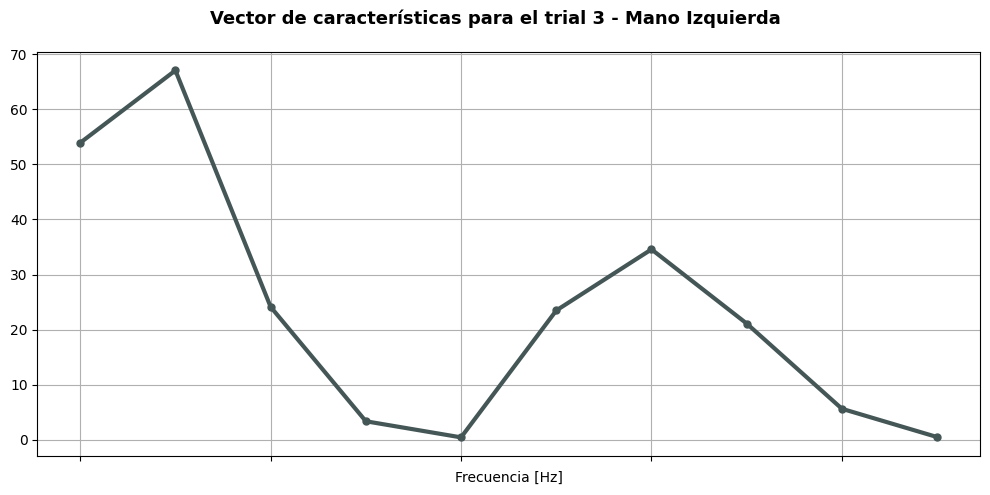

In [243]:

trial = 3
fig, axes = plt.subplots(1,1, figsize = (10,5), sharex=True)

for i,componente in enumerate([1]):
    axes.plot(eeg_ravel[trial-1,:],
                 color = "#455656", linewidth = 3, marker = "o", markersize = 5)
    # axes.set_title(f"Componente {componente}", fontsize = 11)
    ## borramos el texto del ticks eje x
    axes.set_xticklabels([])
    axes.grid()

##agrego subtitulo con negrita y tamaño 16
fig.suptitle(f"Vector de características para el trial {trial} - Mano Izquierda", fontsize=13, fontweight="bold")
plt.xlabel("Frecuencia [Hz]")
plt.tight_layout()
plt.show()

In [217]:
eeg_train_pipeline = pipeline[:-1].transform(eeg_train)
p1 = eeg_train_pipeline[:,:5]
p2 = eeg_train_pipeline[:,10:15]
eeg_train_pipeline = np.concatenate((p1, p2), axis = 1)

In [218]:
labels_train

array([2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 2, 1, 2, 1])

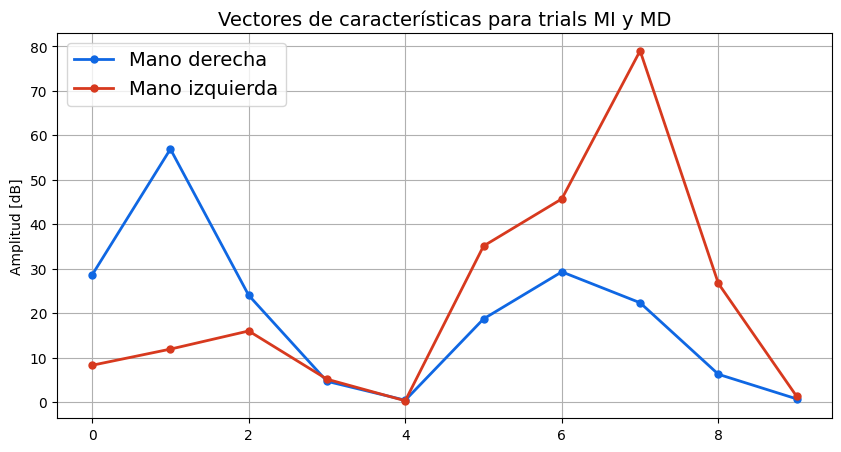

In [238]:
plt.figure(figsize = (10,5))

plt.plot(eeg_train_pipeline[3,:], label = "Mano derecha", color = "#0f67e3", linewidth = 2, marker = "o", markersize = 5)
plt.plot(eeg_train_pipeline[4,:], label = "Mano izquierda", color = "#d7391e", linewidth = 2, marker = "o", markersize = 5)
plt.ylabel("Amplitud [dB]")
#colocamos leyenda arriba a la izquierda con tamaño de fuente 11
plt.legend(loc = "upper left", fontsize = 14)
plt.title("Vectores de características para trials MI y MD", fontsize = 14)
plt.grid()
plt.show()